In [1]:
using Distributions
using StatsBase: ecdf
using StatsFuns: logsumexp
using StatsPlots
default(fmt=:png,
    titlefontsize=10, plot_titlefontsize=10,
    guidefontsize=9, legendfontsize=8, tickfontsize=6)

$$
\begin{aligned}
p(x|a,b)
&= (1-a)\frac{e^{-x^2/2}}{\sqrt{2\pi}} + a\frac{e^{-(x-b)^2/2}}{\sqrt{2\pi}}
\\ &= \frac{e^{-x^2/2}}{\sqrt{2\pi}}
\left(
1 - a + a e^{bx-b^2/2}
\right)
\\ &= \frac{e^{-x^2/2}}{\sqrt{2\pi}}
\left(
1 + a\left(e^{b(x-b/2)} - 1\right)
\right)
\end{aligned}
$$

のとき

$$
\log p(x|a,b) 
= -\frac{x^2}{2} - \log\sqrt{2\pi}
+ \log\left(
1 + a\left(e^{b(x-b/2)} - 1\right)
\right).
$$

データ $X=(x_1,\ldots,x_n)$ の対数尤度:

$$
L(a,b|X) = \sum_{i=1}^n \log p(x_i|a,b).
$$

In [2]:
?log1p

search: log1p log10



```
log1p(x)
```

Accurate natural logarithm of `1+x`. Throws [`DomainError`](@ref) for [`Real`](@ref) arguments less than -1.

# Examples

```jldoctest; filter = r"Stacktrace:(\n \[[0-9]+\].*)*"
julia> log1p(-0.5)
-0.6931471805599453

julia> log1p(0)
0.0

julia> log1p(-2)
ERROR: DomainError with -2.0:
log1p will only return a complex result if called with a complex argument. Try log1p(Complex(x)).
Stacktrace:
 [1] throw_complex_domainerror(::Symbol, ::Float64) at ./math.jl:31
[...]
```


In [3]:
?expm1

search: expm1



```
expm1(x)
```

Accurately compute $e^x-1$. It avoids the loss of precision involved in the direct evaluation of exp(x)-1 for small values of x.

# Examples

```jldoctest
julia> expm1(1e-16)
1.0e-16

julia> exp(1e-16) - 1
0.0
```


In [4]:
mixnormal(a, b) = MixtureModel([Normal(), Normal(b, 1)], [1-a, a])

function logpdf_mixnormal(a, b, x)
    -x^2/2 - log(√(2π)) + log1p(a*expm1(b*(x - b/2)))
end

function pdf_mixnormal(a, b, x)
    exp(logpdf_mixnormal(a, b, x))
end

function loglik_mixnormal(a, b, X)
    sum(logpdf_mixnormal(a, b, x) for x in X)
end

loglik_mixnormal (generic function with 1 method)

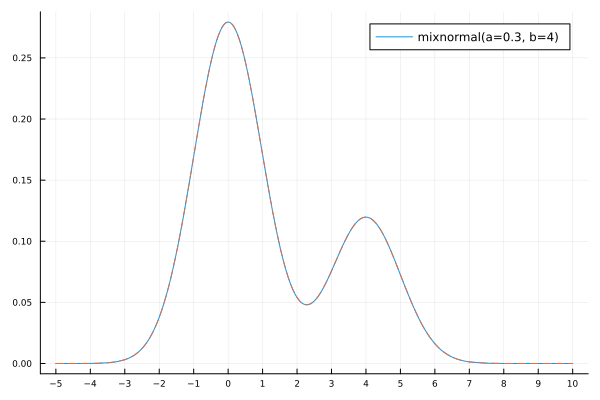

In [5]:
X = randn(10)
a, b = 0.3, 4
plot(x -> pdf_mixnormal(a, b, x), -5, 10; label="mixnormal(a=$a, b=$b)")
plot!(x -> pdf(mixnormal(a, b), x), -5, 10; label="", ls=:dash)
plot!(; xtick=-10:10)

In [6]:
function plot_lik_mixnormal(; a = 0.5, b = 1.0, n = 100)
    as = range(0, 1, 400)
    bs = range(-4, 4, 400)
    ws = Vector{Matrix{Float64}}(undef, 20)
    Threads.@threads for i in 1:20
        X = rand(mixnormal(a, b), n)
        logz = loglik_mixnormal.(as, bs', Ref(X))
        maxlogz = maximum(logz)
        ws[i] = @. exp(logz - maxlogz)
    end
    PP = Vector{Any}(undef, 20)
    for i in 1:20
        P = heatmap(bs, as, ws[i]; colorbar=false, tickfontsize=5)
        plot!(xtick=-10:10, ytick=-0:0.1:1)
        PP[i] = P
    end
    plot(PP...; layout=(4, 5), size=(1000, 800))
    plot!(plot_title="true a = $a,  true b = $b,  n = $n")
end

plot_lik_mixnormal (generic function with 1 method)

  2.766083 seconds (3.73 M allocations: 298.117 MiB, 3.25% gc time, 63.46% compilation time: 26% of which was recompilation)


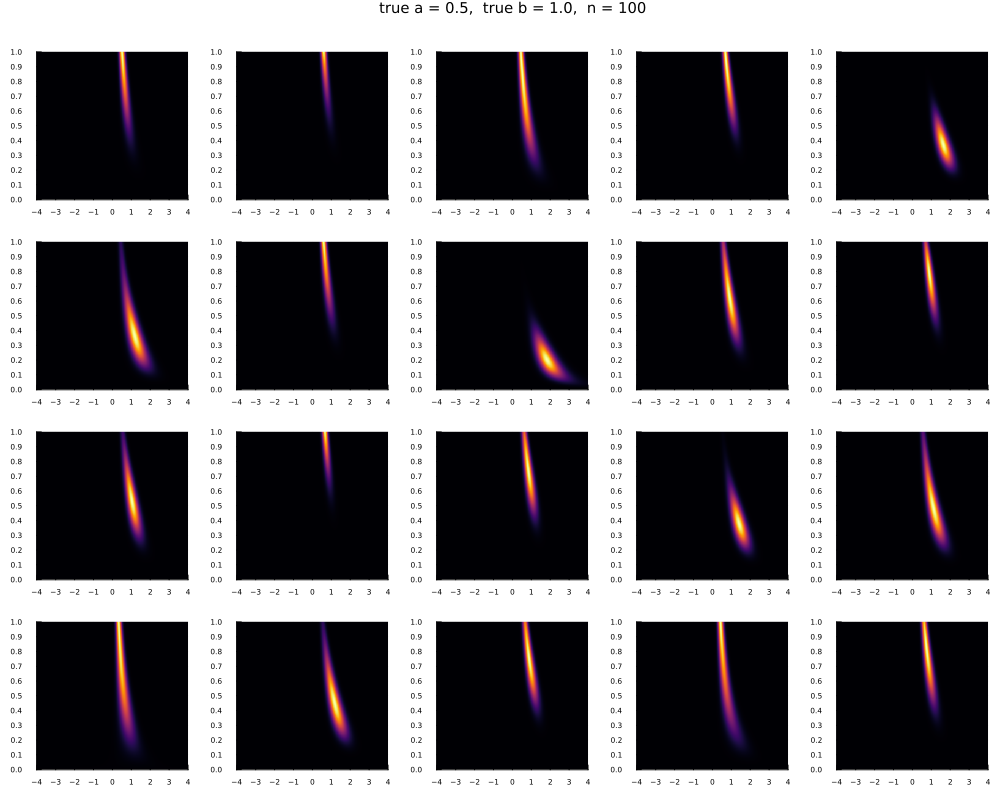

In [7]:
@time plot_lik_mixnormal(; a = 0.5, b = 1.0, n = 100)

  1.076645 seconds (57.29 k allocations: 102.583 MiB, 1.19% gc time)


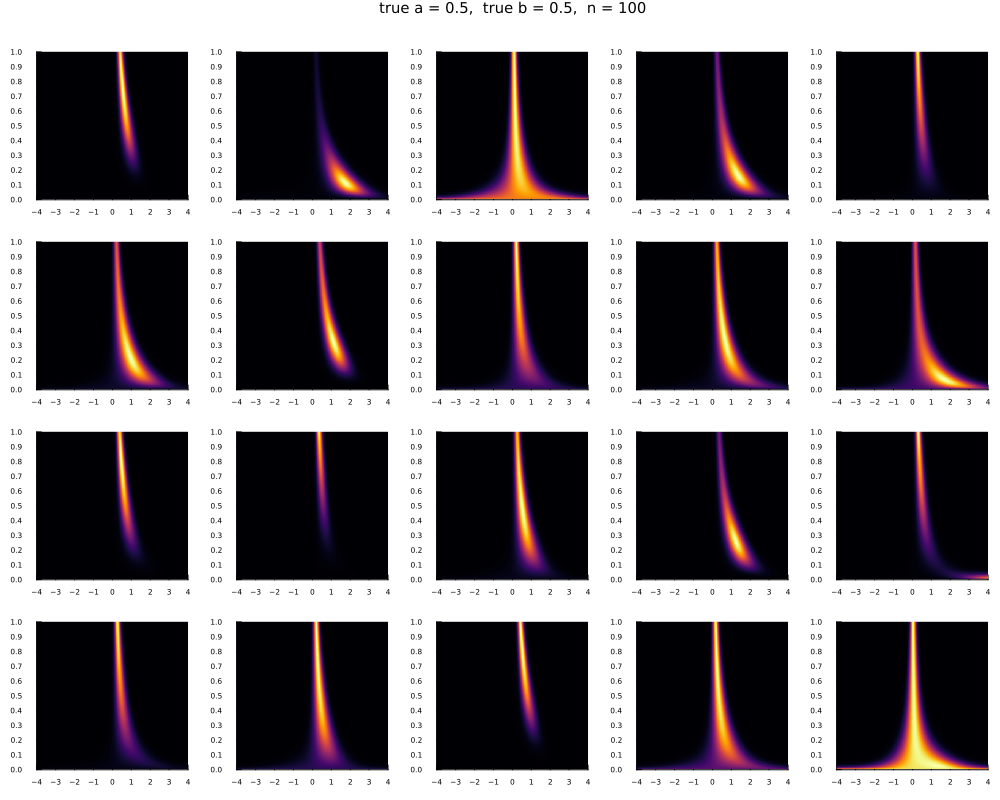

In [8]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.5, n = 100)

  1.060400 seconds (57.29 k allocations: 102.584 MiB)


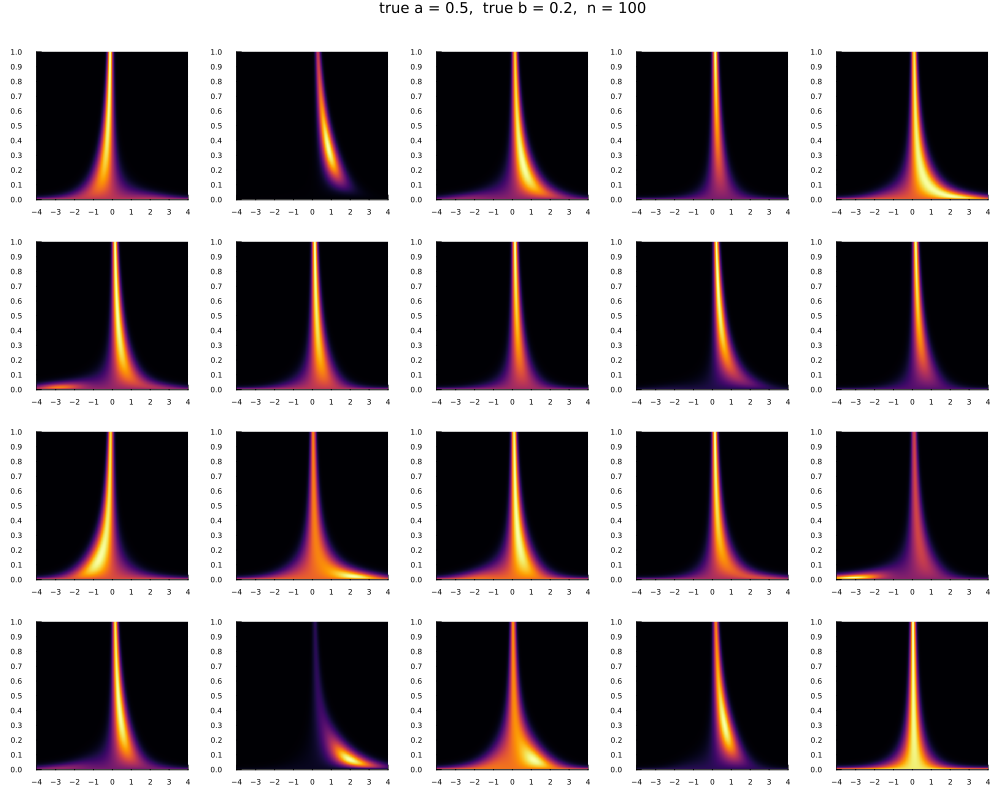

In [9]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.2, n = 100)

  1.089990 seconds (57.29 k allocations: 102.582 MiB, 3.87% gc time)


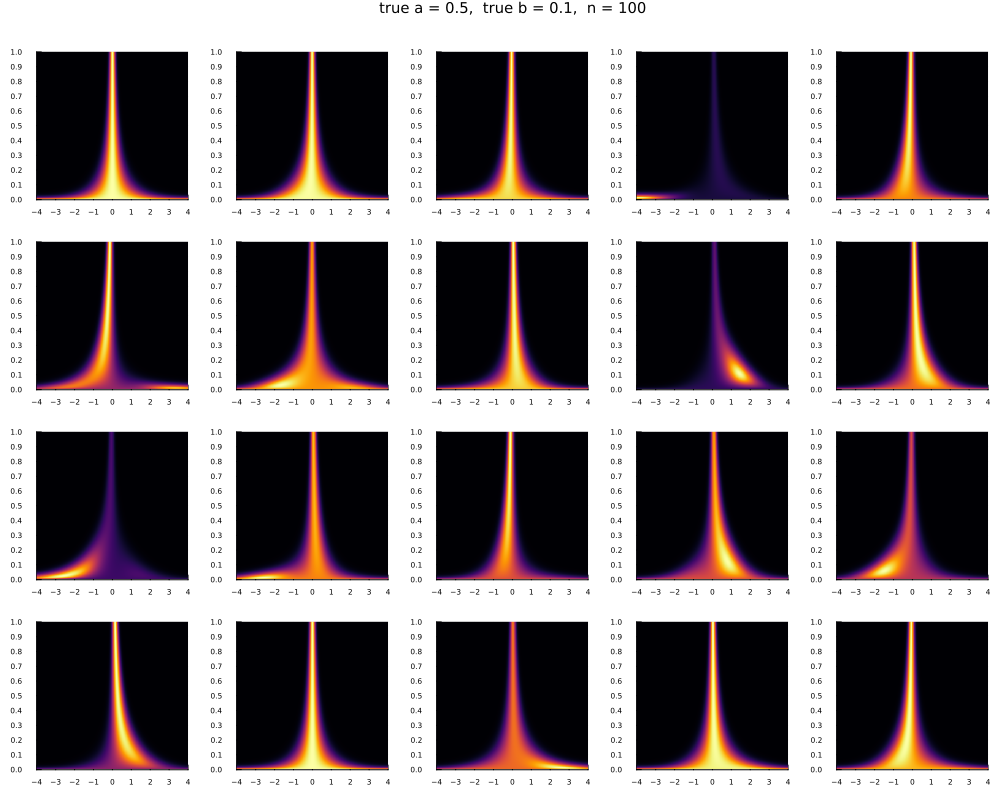

In [10]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.1, n = 100)

  1.087421 seconds (57.28 k allocations: 102.581 MiB, 1.28% gc time)


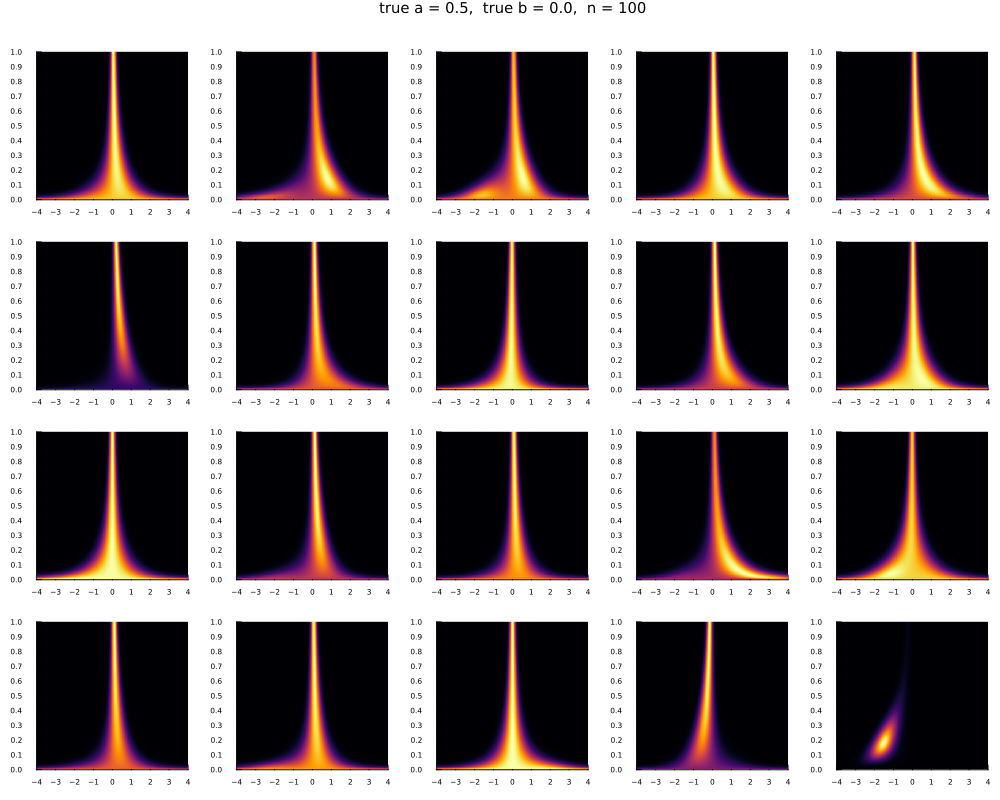

In [11]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.0, n = 100)

モデル:

$$
p(y|a,b,x) = \frac{1}{\sqrt{2\pi}}\exp\left(\frac{(y - b\tanh ax)^2}{2}\right).
$$

データ $X=(x_1,\ldots,x_n)$, $Y=(y_1,\ldots,y_n)$ の対数尤度:

$$
\log L(a,b|X,Y) = \sum_{i=1}^n \log p(y_i|a,b,x_i).
$$

In [12]:
regtanh(a, b, x) = Normal(b*tanh(a*x), 1)
loglik_regtanh(a, b, X, Y) = sum(logpdf(regtanh(a, b, x), y) for (x, y) in zip(X, Y))

loglik_regtanh (generic function with 1 method)

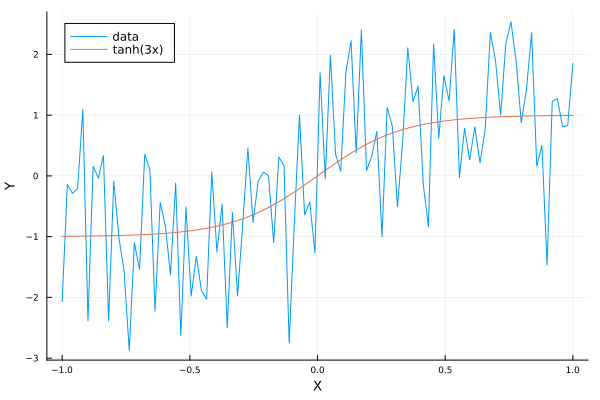

In [13]:
a, b, n = 3, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

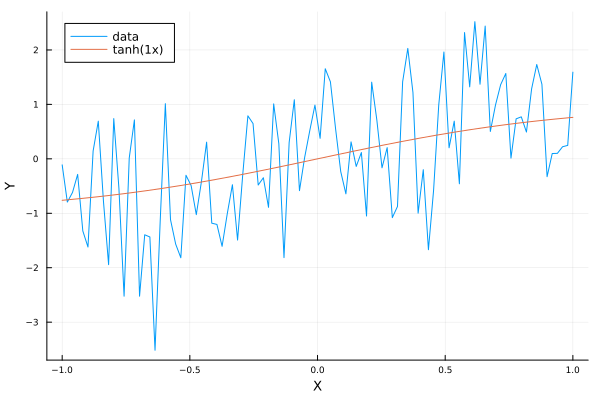

In [14]:
a, b, n = 1, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

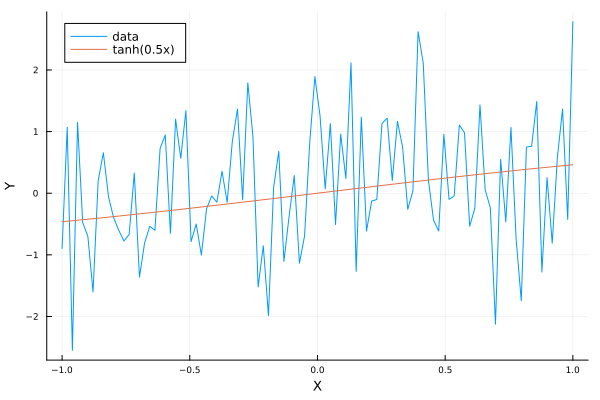

In [15]:
a, b, n = 0.5, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

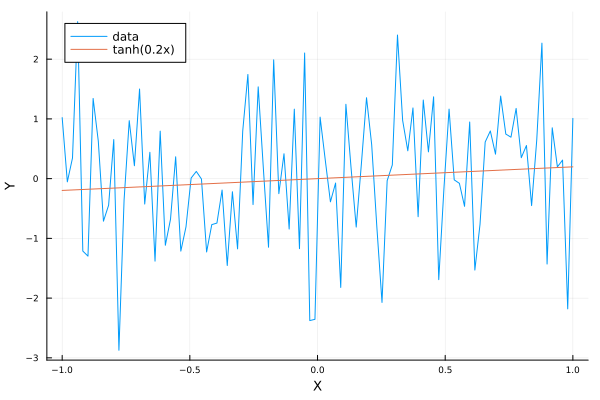

In [16]:
a, b, n = 0.2, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

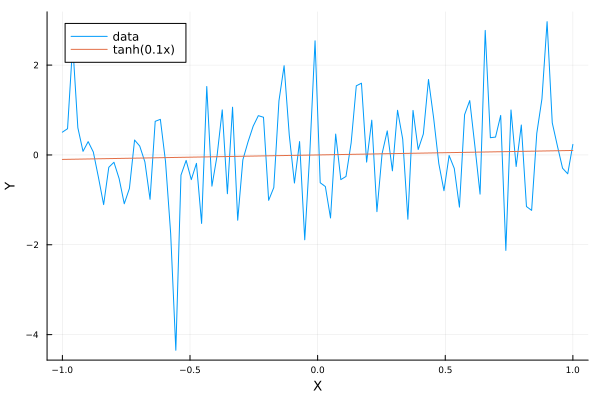

In [17]:
a, b, n = 0.1, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

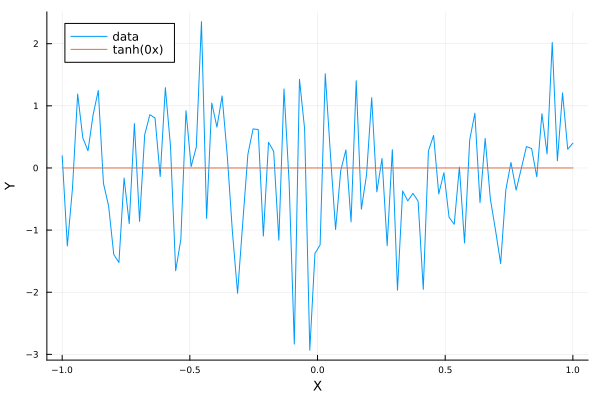

In [18]:
a, b, n = 0, 1, 100
X = range(-1, 1, n)
Y = [rand(regtanh(a, b, x)) for x in X]
plot(X, Y; label="data")
plot!(; xguide="X", yguide="Y")
plot!(x -> b*tanh(a*x), -1, 1; label="$(b==1 ? "" : "$b ")tanh($(a)x)")
plot!(legend=:topleft)

In [19]:
function plog_lik_regtanh(; a=1, b=1, n=100)
    X = range(-1, 1, n)
    as = range(-3, 3, 400)
    bs = range(-3, 3, 400)
    ws = Vector{Matrix{Float64}}(undef, 20)
    Threads.@threads for i in 1:20
        Y = [rand(regtanh(a, b, x)) for x in X]
        logz = loglik_regtanh.(as, bs', Ref(X), Ref(Y))
        maxlogz = maximum(logz)
        ws[i] = @. exp(logz - maxlogz)
    end
    PP = Vector{Any}(undef, 20)
    for i in 1:20
        P = heatmap(bs, as, ws[i]; colorbar=false, tickfontsize=5)
        plot!(xtick=-10:10, ytick=-10:10)
        PP[i] = P
    end
    plot(PP...; layout=(4, 5), size=(1000, 800))
    plot!(plot_title="true a = $a,  true b = $b,  n = $n")
end

plog_lik_regtanh (generic function with 1 method)

  1.554612 seconds (1.07 M allocations: 153.203 MiB, 19.53% compilation time)


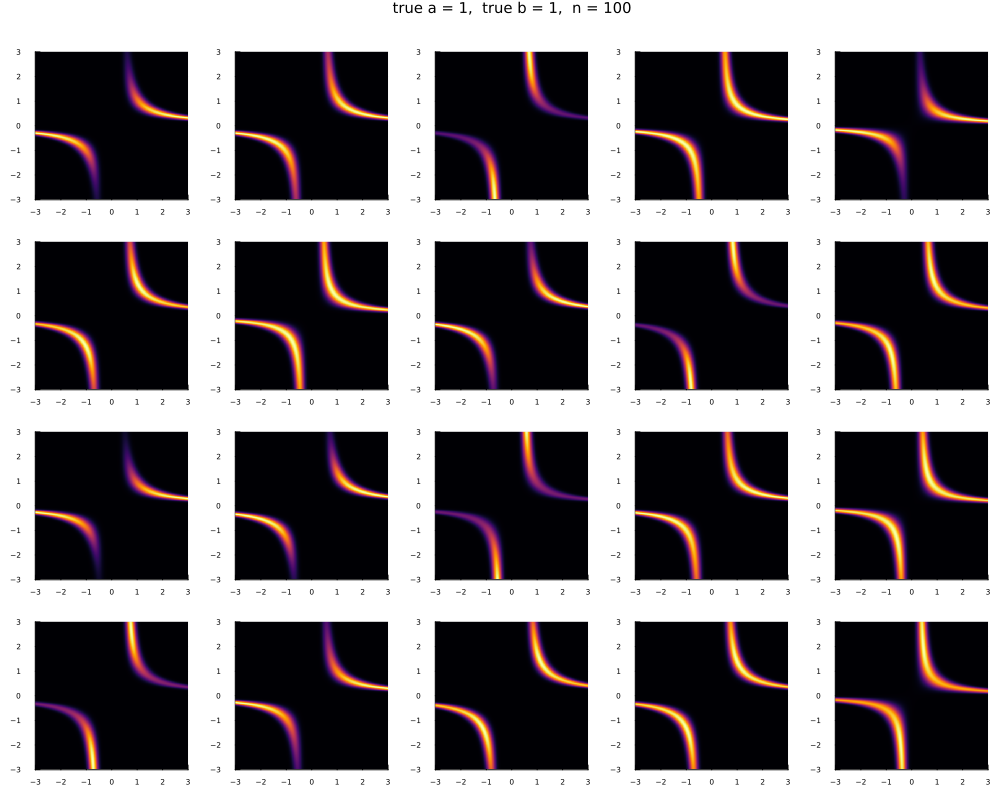

In [20]:
@time plog_lik_regtanh(; a=1, b=1, n=100)

  1.359508 seconds (170.87 k allocations: 107.904 MiB, 7.28% compilation time)


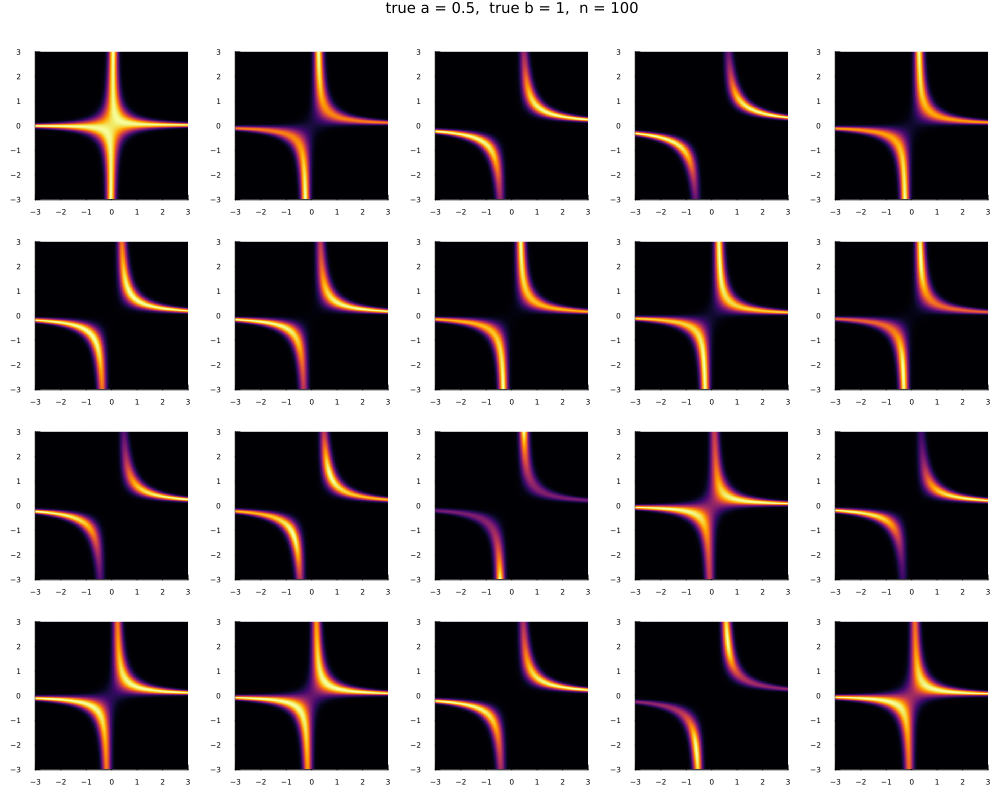

In [21]:
@time plog_lik_regtanh(; a=0.5, b=1, n=100)

  1.412274 seconds (57.16 k allocations: 102.563 MiB)


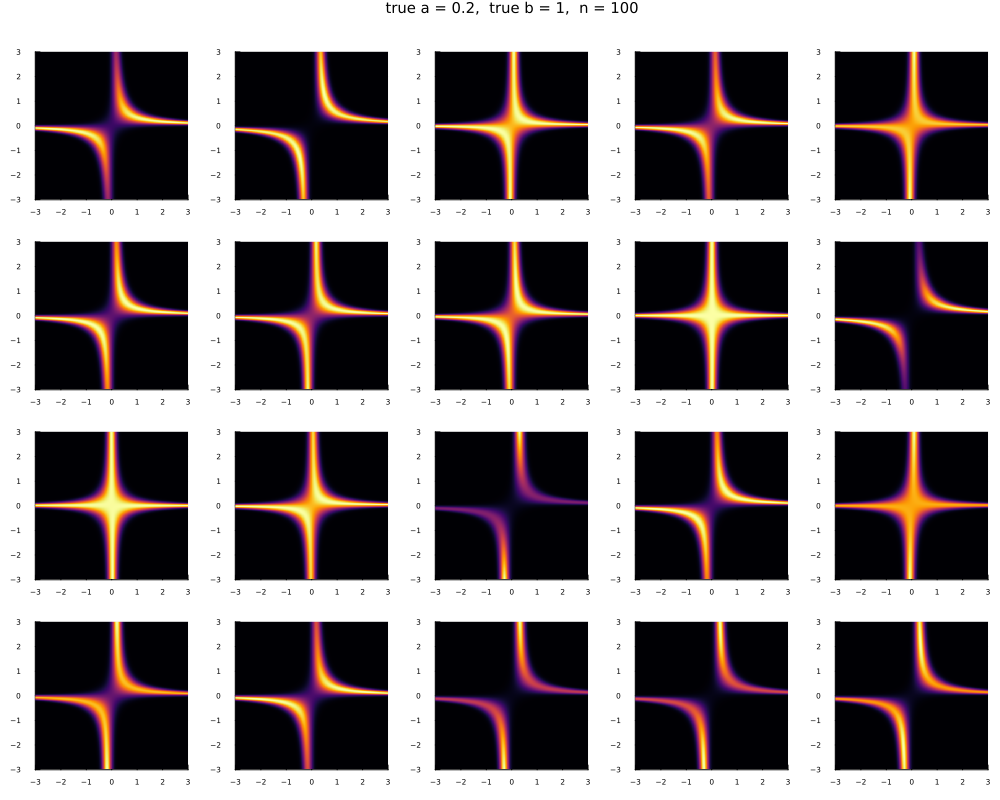

In [22]:
@time plog_lik_regtanh(; a=0.2, b=1, n=100)

  1.202422 seconds (57.15 k allocations: 102.564 MiB, 1.38% gc time)


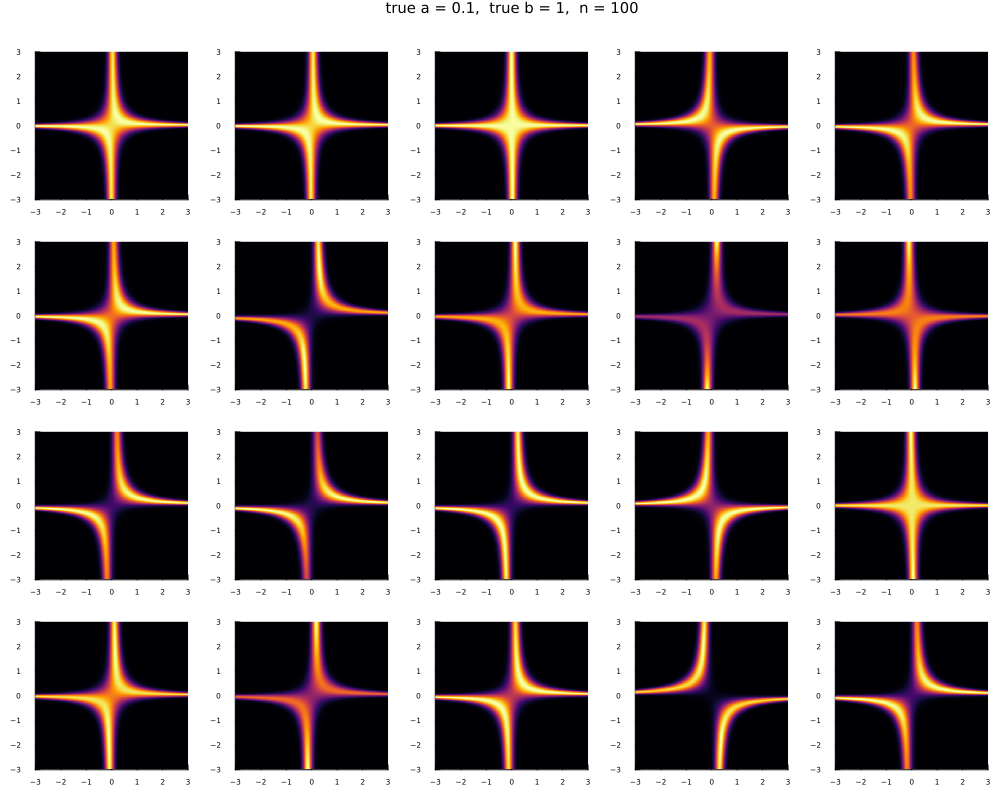

In [23]:
@time plog_lik_regtanh(; a=0.1, b=1, n=100)

  1.324437 seconds (57.16 k allocations: 102.562 MiB)


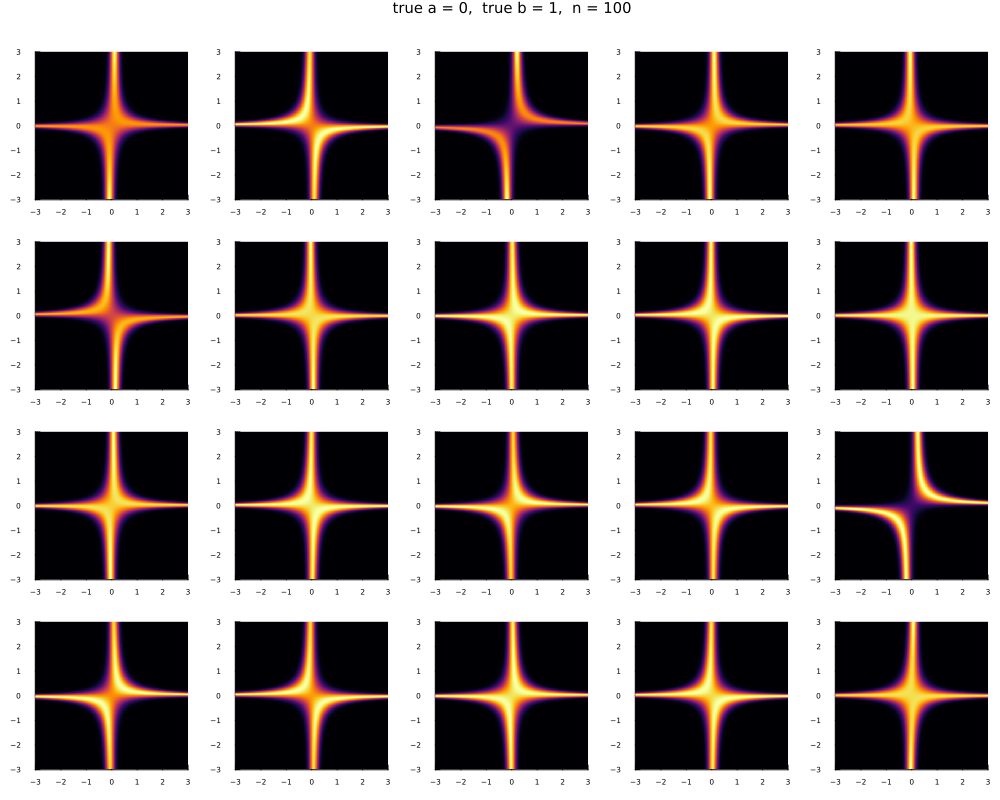

In [24]:
@time plog_lik_regtanh(; a=0, b=1, n=100)

 11.751110 seconds (57.30 k allocations: 102.706 MiB)


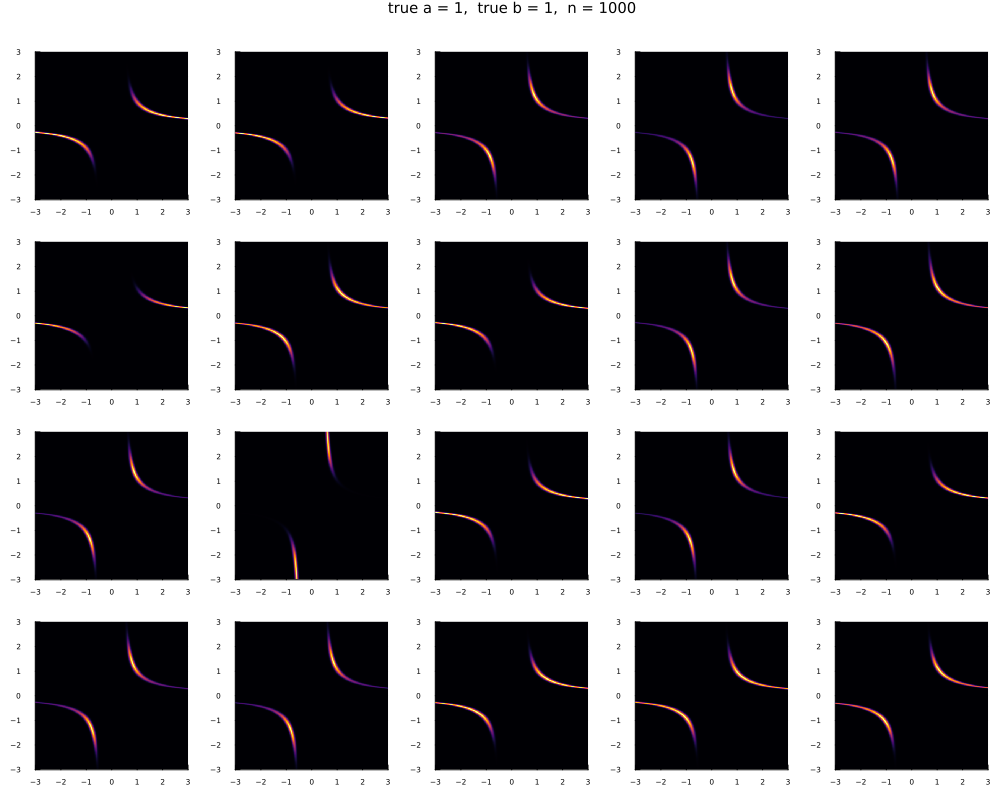

In [25]:
@time plog_lik_regtanh(; a=1, b=1, n=1000)

 11.787883 seconds (57.29 k allocations: 102.706 MiB, 0.23% gc time)


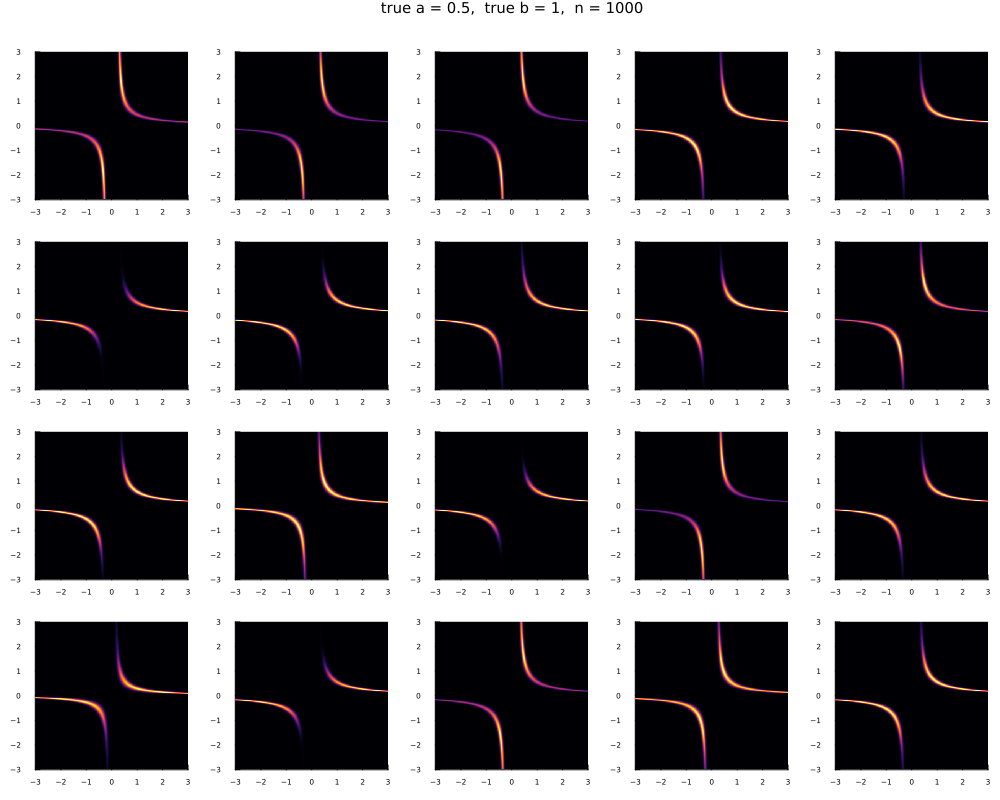

In [26]:
@time plog_lik_regtanh(; a=0.5, b=1, n=1000)

 11.985498 seconds (57.32 k allocations: 102.707 MiB)


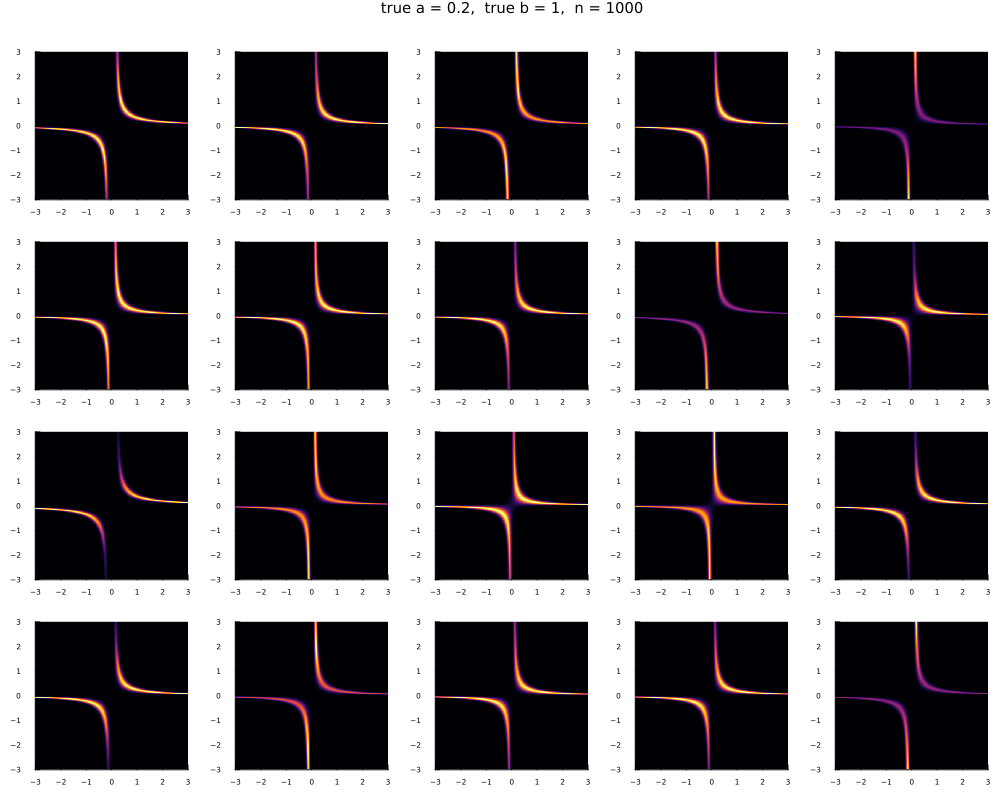

In [27]:
@time plog_lik_regtanh(; a=0.2, b=1, n=1000)

 12.385277 seconds (57.31 k allocations: 102.704 MiB)


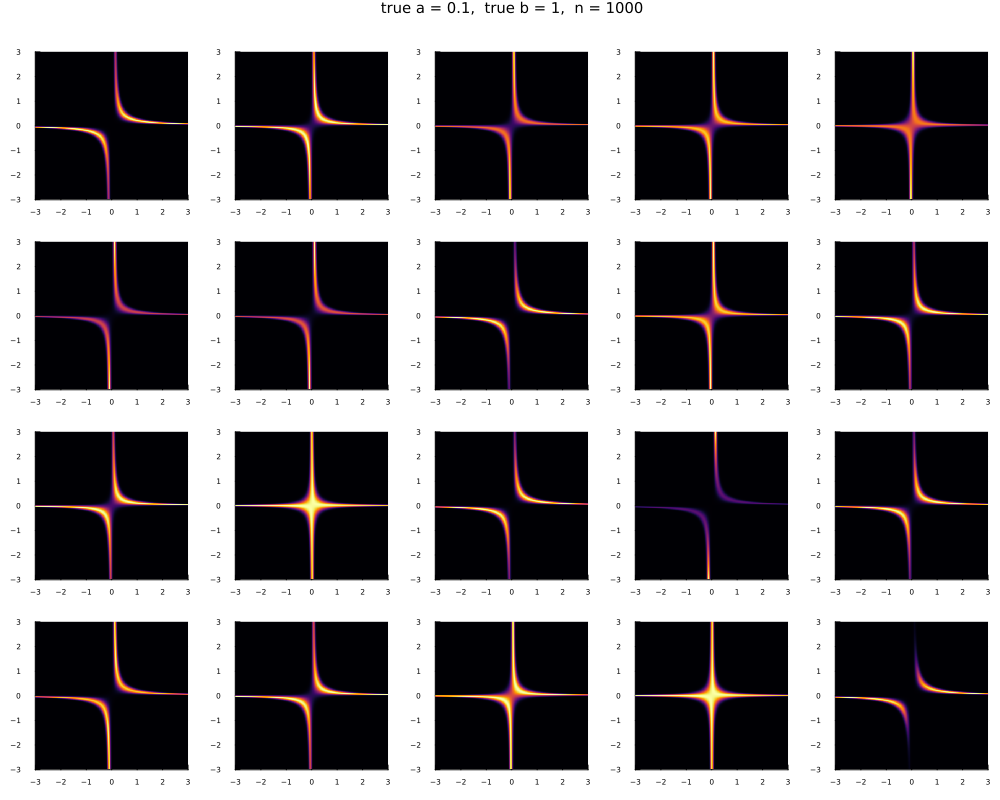

In [28]:
@time plog_lik_regtanh(; a=0.1, b=1, n=1000)

 11.946732 seconds (57.30 k allocations: 102.706 MiB, 0.37% gc time)


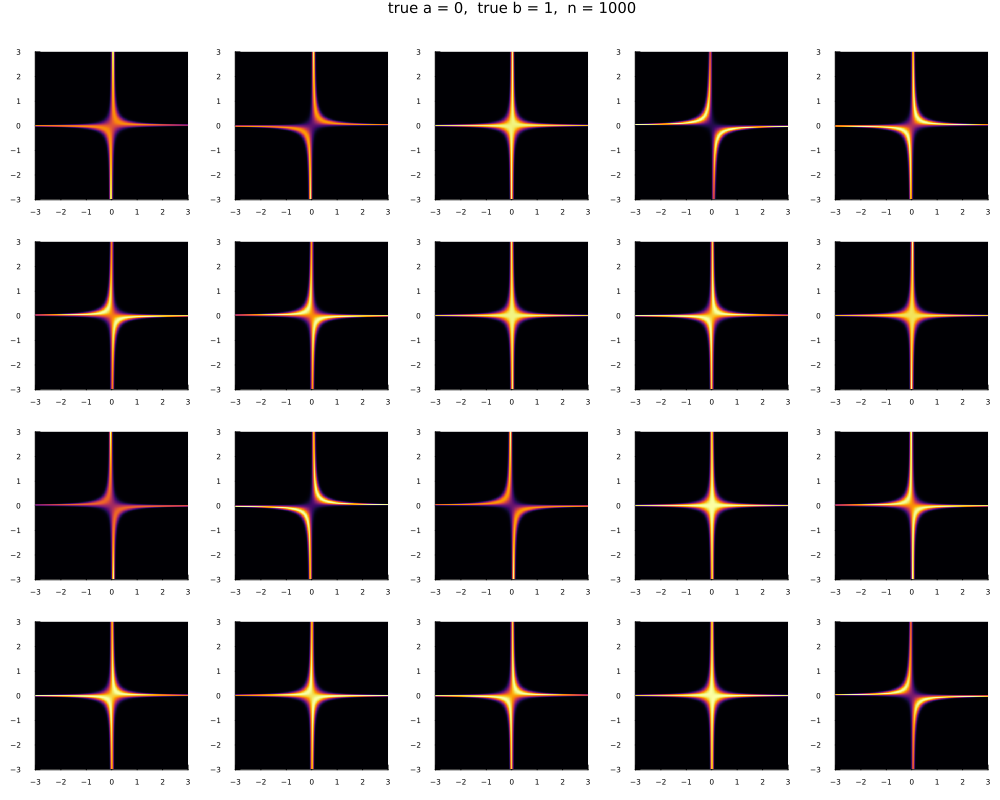

In [29]:
@time plog_lik_regtanh(; a=0, b=1, n=1000)